In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author: Sidi Wu and Cédric Beaulac

Functional autoencoder implementation
"""

# Import modules
import sys
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
import sklearn
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev
import skfda

import skfda
from skfda import FDataGrid as fd
from skfda.representation.basis import Fourier, BSpline



In [3]:

# os.chdir('C:/FAE')
os.chdir('C:/Users/Utilisateur/Documents/Master_SSD/STAGE_RECHERCHE/FDA_python')
if not os.getcwd() in sys.path:
    sys.path.append(os.getcwd())

# CÉDRIC: Je pense pas que t'aie besoin de ça en ce moment

import DataGenerator
from DataGenerator import *
import DataGenerator_NN
from DataGenerator_NN import *
import Functions
from Functions import *


In [59]:
help(DataGenerator)

Help on function DataGenerator in module DataGenerator:

DataGenerator(nc=250, tpts=array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), classes=4, noise=2)
    # nc: number of data points per *class*, classes: number of classes/cluster, noise:std of the normal noise



In [7]:
##Importation des données sous forme FDA

ElNino_OISST_region_1and2=skfda.datasets.fetch_cran("ElNino_OISST_region_1and2","rainbow")
ElNino_OISST_region_3=skfda.datasets.fetch_cran("ElNino_OISST_region_3","rainbow")
ElNino_OISST_region_4=skfda.datasets.fetch_cran("ElNino_OISST_region_4","rainbow")
ElNino_OISST_region_3and4=skfda.datasets.fetch_cran("ElNino_OISST_region_3and4","rainbow")


c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fds". The underlying R object is returned instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" w

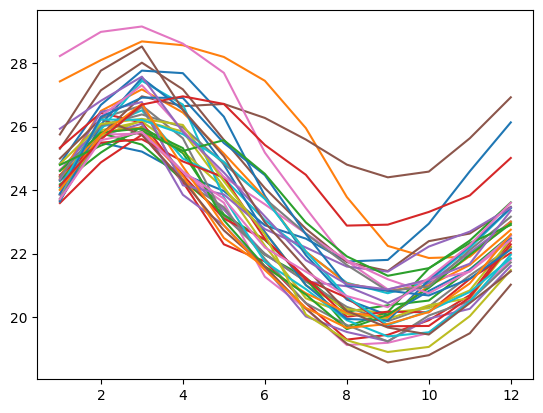

In [8]:
ElNino_OISST_region_1and2_y=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['y'].to_numpy()
ElNino_OISST_region_1and2_x=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['x']
plt.plot(ElNino_OISST_region_1and2_x,ElNino_OISST_region_1and2_y)
plt.show(
)

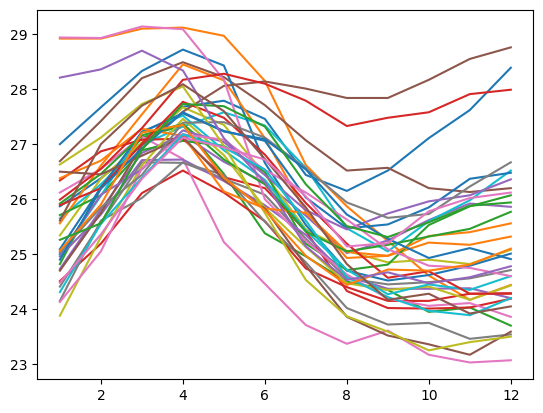

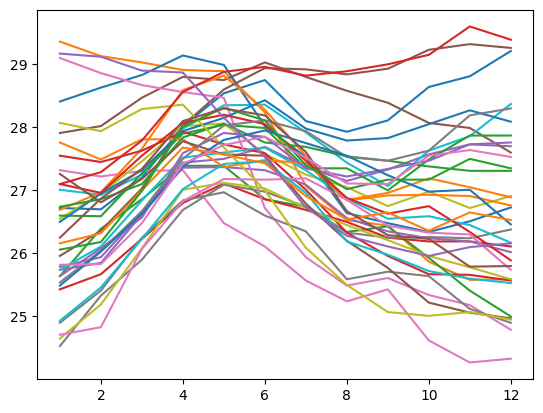

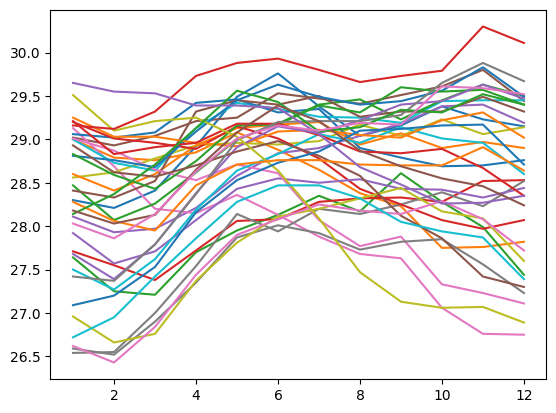

In [9]:
ElNino_OISST_region_3_y=ElNino_OISST_region_3['ElNino_OISST_region_3']['y'].to_numpy()
ElNino_OISST_region_3_x=ElNino_OISST_region_3['ElNino_OISST_region_3']['x']
plt.plot(ElNino_OISST_region_3_x,ElNino_OISST_region_3_y)
plt.show(

)
ElNino_OISST_region_3and4_y=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['y'].to_numpy()
ElNino_OISST_region_3and4_x=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['x']
plt.plot(ElNino_OISST_region_3and4_x,ElNino_OISST_region_3and4_y)
plt.show(
)


ElNino_OISST_region_4_y=ElNino_OISST_region_4['ElNino_OISST_region_4']['y'].to_numpy()
ElNino_OISST_region_4_x=ElNino_OISST_region_4['ElNino_OISST_region_4']['x']
plt.plot(ElNino_OISST_region_4_x,ElNino_OISST_region_4_y)
plt.show(
)

In [10]:
grid_points=ElNino_OISST_region_1and2_x
[ElNino_OISST_region_1and2_y.shape,

print("grid_points=",grid_points)]

grid_points= [ 1  2  3  4  5  6  7  8  9 10 11 12]


[(12, 37), None]

In [11]:
x0=torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
x1=torch.tensor(ElNino_OISST_region_3_y).float().cuda()
x2=torch.tensor(ElNino_OISST_region_4_y).float().cuda()
x3=torch.tensor(ElNino_OISST_region_3and4_y).float().cuda()
x0=torch.t(x0)
x1=torch.t(x1)
x2=torch.t(x2)
x3=torch.t(x3)

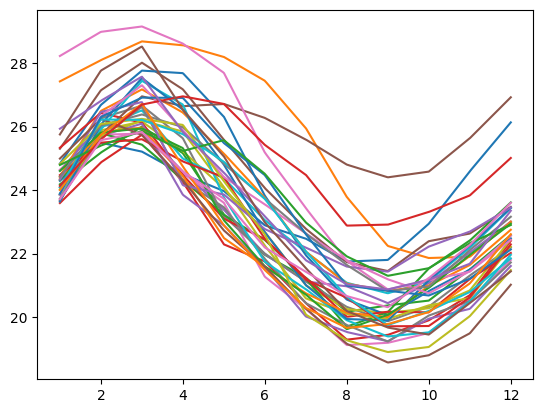

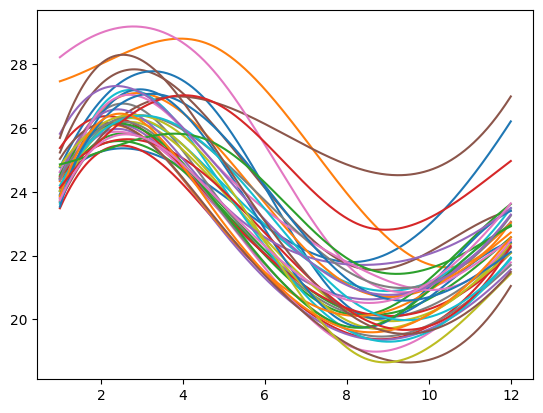

In [12]:
x0_grid=fd(torch.t(torch.tensor(ElNino_OISST_region_1and2_y)),grid_points=ElNino_OISST_region_1and2_x)
basis= skfda.representation.basis.BSpline(knots=np.linspace(1,12,4),order=4)
fd_basis=x0_grid.to_basis(basis=basis)
x0_grid.plot()
fd_basis.plot()
plt.show()

On choisi le lissage par Bspline dont la base est déterminée par les noeuds linspace(1,12,4) et un order 4 d'interpolation.
Le nombre de basis est donc égale à :
(4+4-2)=6 



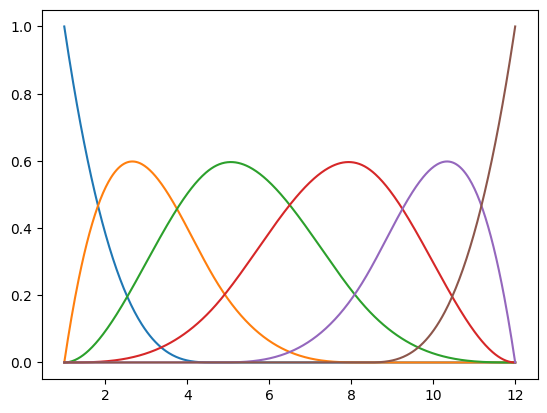

In [13]:
basis.plot()

In [251]:
class FCNN(nn.Module):
    def __init__(self,n_basis=6):
        super(FCNN,self).__init__()          
        self.CNN_Conv=nn.Sequential(    
            nn.Conv1d(1,64,kernel_size=5,stride=[1],padding=[1],bias =True,dilation=1),         
        )    
        self.Linear=nn.Sequential(
           
            nn.Flatten(),
            nn.Linear(640,64),
            nn.LeakyReLU(0.15,inplace=True),
            nn.Linear(64,4),
        )
    def forward(self,functions):
        functions=functions.float().cuda()
        conv_out=self.CNN_Conv(functions)
        Linear_out=self.Linear(conv_out)
        return Linear_out.float().unsqueeze_(dim=2).unsqueeze_(dim=3)

In [15]:
x =torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
w = x.size(1)-1
W = torch.tensor([1/(2*w)]+[1/w]*(w-1)+[1/(2*w)])
W
x.size()
basis


BSplineBasis(domain_range=((1.0, 12.0),), n_basis=6, order=4, knots=(1.0, 4.666666666666666, 8.333333333333332, 12.0))

In [16]:

FD_grid_region_1and_2=fd(x0.detach().cpu(),grid_points=ElNino_OISST_region_1and2_x)
FD_grid_region_3=fd(x1.detach().cpu(),grid_points=ElNino_OISST_region_3_x)
FD_grid_region_4=fd(x2.detach().cpu(),grid_points=ElNino_OISST_region_4_x)
FD_grid_region_3and_4=fd(x3.detach().cpu(),grid_points=ElNino_OISST_region_3and4_x)

##Une fois les coefficients récupérés, on en fait une fonction de x puis 
##x vaudra une discrétisation du temps.
##On va zoomer la courbe pour faire de la convolution.


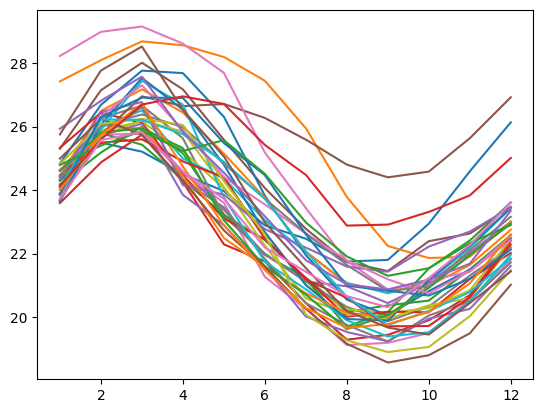

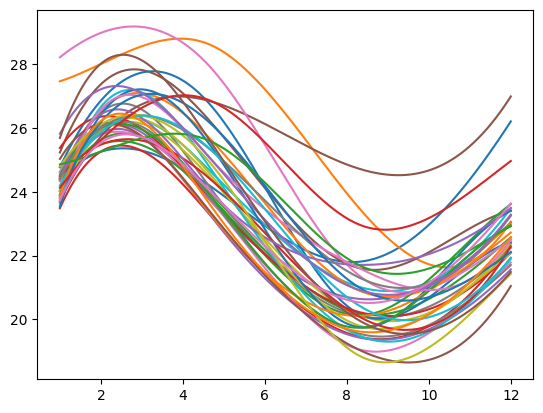

In [17]:

fd(x0.detach().cpu(),grid_points=ElNino_OISST_region_1and2_x).plot()
plt.show()
FD_grid_region_1and_2.to_basis(basis).plot()
plt.show()

In [18]:
x0=x0.reshape(37,1,12)
x1=x1.reshape(37,1,12)
x2=x2.reshape(37,1,12)
x3=x3.reshape(37,1,12)


In [127]:
x0=torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
x1=torch.tensor(ElNino_OISST_region_3_y).float().cuda()
x2=torch.tensor(ElNino_OISST_region_4_y).float().cuda()
x3=torch.tensor(ElNino_OISST_region_3and4_y).float().cuda()
x0=torch.t(x0)
x1=torch.t(x1)
x2=torch.t(x2)
x3=torch.t(x3)

# train_index=np.random.permutation(torch.tensor(np.arange(30)))
# train_index_long=np.random.permutation(torch.tensor(np.arange(148)))
# x0_train,y0_train=x0[train_index,:],torch.zeros(len(x0))[train_index]
# x1_train,y1_train=x1[train_index,:],torch.ones(len(x0))[train_index]
# x2_train,y2_train=x2[train_index,:],torch.ones(len(x0))[train_index]*2
# x3_train,y3_train=x3[train_index,:],torch.ones(len(x0))[train_index]*3
# X_train=torch.concatenate([x0_train,x1_train,x2_train,x3_train],axis=0)
# Y_train=torch.concatenate([y0_train,y1_train,y2_train,y3_train],axis=0)
# Y=Y_train.cuda()
# X_test=torch.concatenate([x0[~train_index],x1[~train_index],x2[~train_index],x3[~train_index]],axis=0)
# Y_test=torch.tensor(labels[~train_index_long])



In [141]:

labels = torch.tensor([0] * x0.shape[0] + [1] * x1.shape[0] + [2] * x2.shape[0] + [3] * x3.shape[0])
X=torch.cat([x0,x1,x2,x3])
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,labels,shuffle=True)
x_train=x_train.reshape(111,1,12).float().cuda()
y_train=y_train.unsqueeze(1).float().cuda()
x_test=x_test.reshape(37,1,12).float().cuda()
y_test=y_test.unsqueeze(1).float().cuda()




x_train de la région 1 et 2


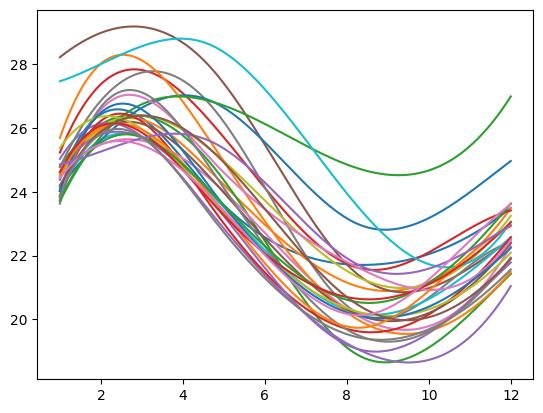

basis d.ordre 4 à 4 noeuds


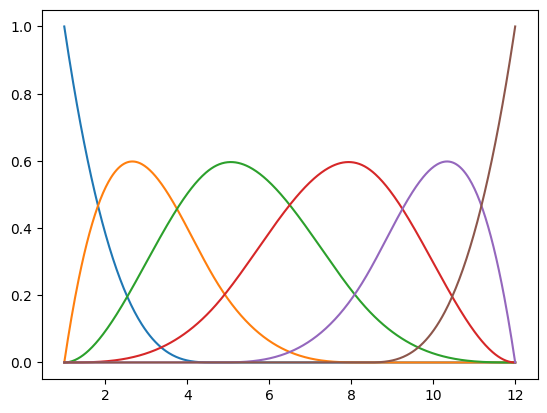

In [130]:
# CEDRIC: Ici tu peux utiliser basis_X coefficients pour recréer un nouveua training X en mutliple les coefficient par des function.eval a plusieurs timestamps
X_grid=fd(x_train[y_train==0].cpu(),grid_points=grid_points)
basis=skfda.representation.basis.BSplineBasis(knots=np.linspace(1,12,4),order=4)
n_basis=basis.n_basis
basis_X=X_grid.to_basis(basis=basis)
basis_fc=torch.tensor(basis_X.coefficients).float().cuda()
basis_X.plot()
print('x_train de la région 1 et 2')
plt.show() 
##Une fois les coefficients récupérés, on en fait une fonction de x puis 
##x vaudra une discrétisation du temps.
##On va zoomer la courbe pour faire de la convolution.
basis_fc.shape
basis.plot()
print('basis d.ordre 4 à 4 noeuds')
plt.show()

x_train de la région 3


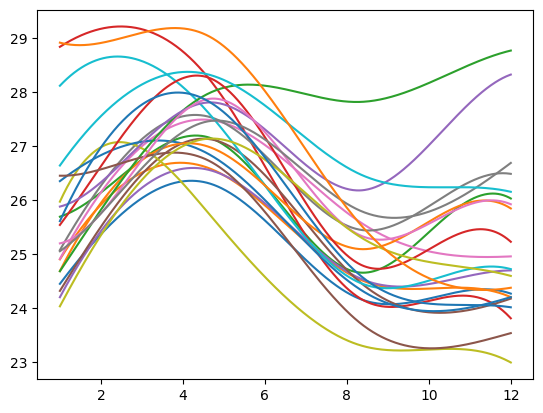

torch.Size([22, 6])

In [106]:

n_rep=64
X_grid=fd(x_train[y_train==1].cpu(),grid_points=grid_points)
basis=skfda.representation.basis.BSplineBasis(knots=np.linspace(1,12,4),order=4)
n_basis=basis.n_basis
basis_X=X_grid.to_basis(basis=basis)
basis_fc=torch.tensor(basis_X.coefficients).float().cuda()
basis_X.plot()
print('x_train de la région 3')
plt.show() 
##Une fois les coefficients récupérés, on en fait une fonction de x puis 
##x vaudra une discrétisation du temps.
##On va zoomer la courbe pour faire de la convolution.
basis_fc.shape


In [131]:

CNN=FCNN()
CNN=CNN.cuda()
Conv_out=CNN.CNN_Conv(x_train)
[x_train.shape,Conv_out.shape]



[torch.Size([111, 1, 12]), torch.Size([111, 64, 10])]

['conv_out shape=', torch.Size([111, 64, 10])]
Courbe d'origine 1


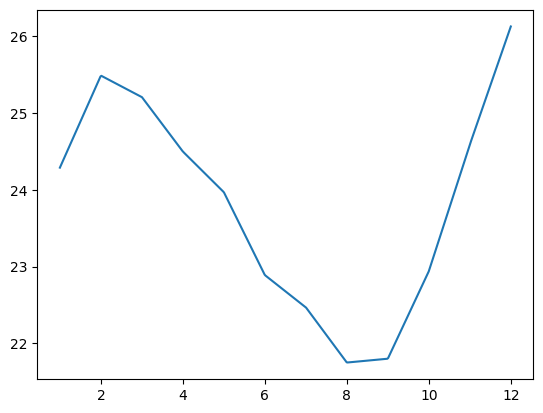

1 1
Convlayer 1


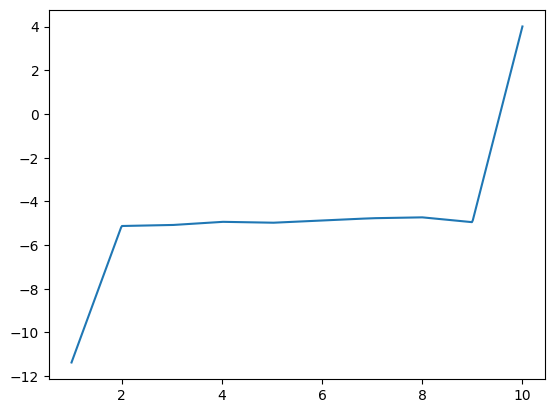

1 2
Convlayer 2


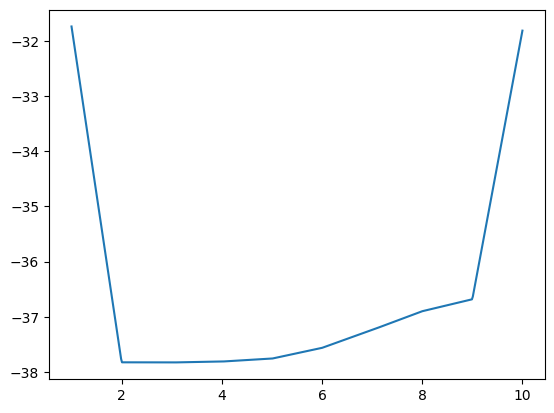

1 3
Convlayer 3


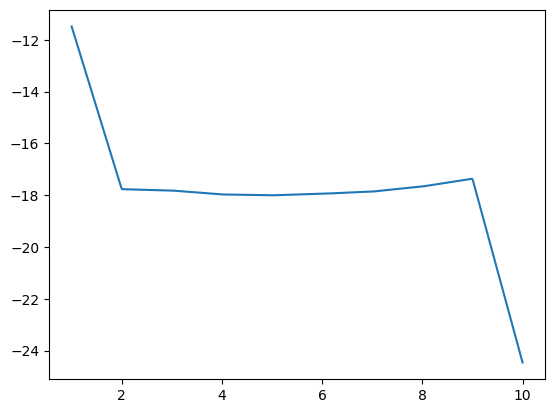

Courbe d'origine 2


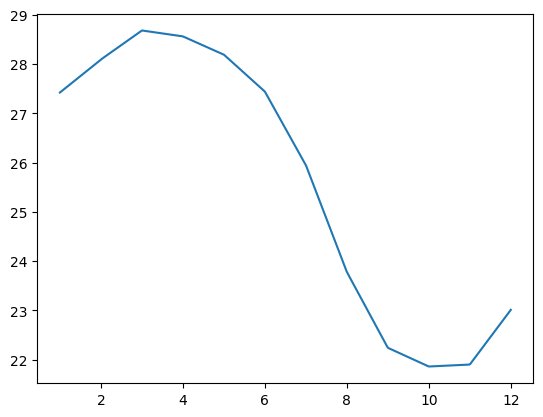

2 1
Convlayer 1


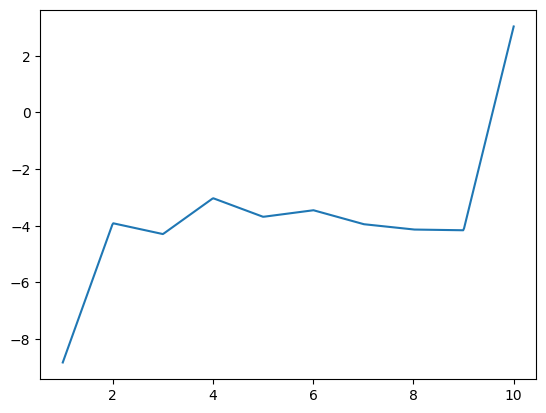

2 2
Convlayer 2


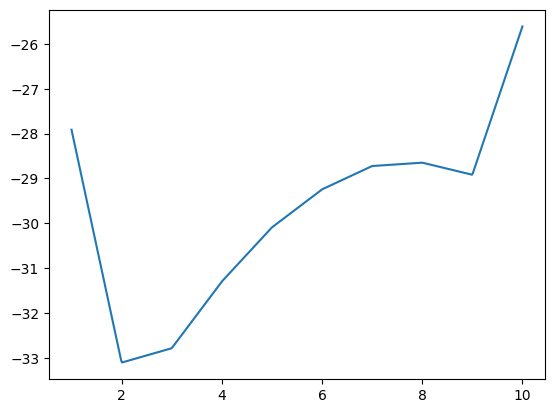

2 3
Convlayer 3


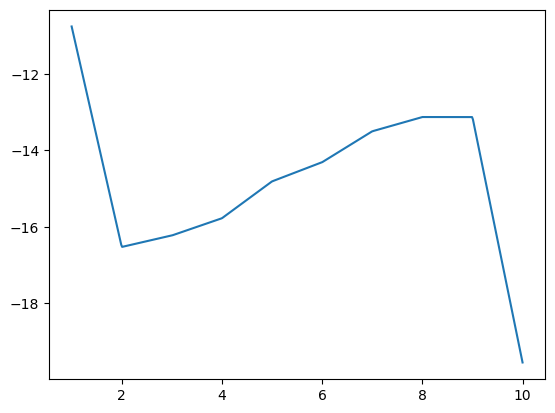

Courbe d'origine 3


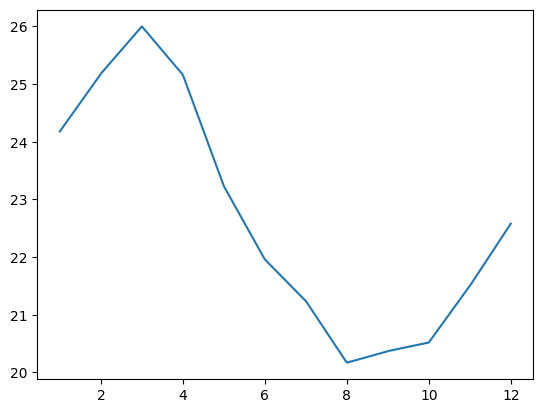

3 1
Convlayer 1


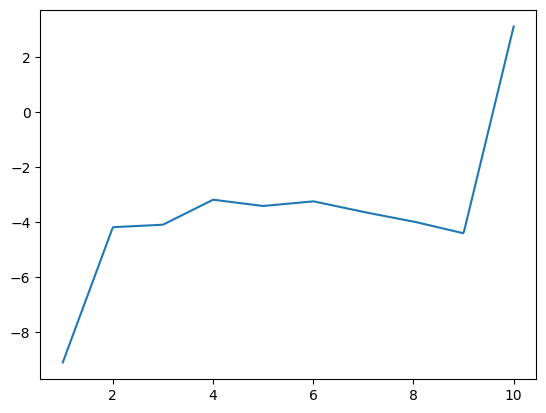

3 2
Convlayer 2


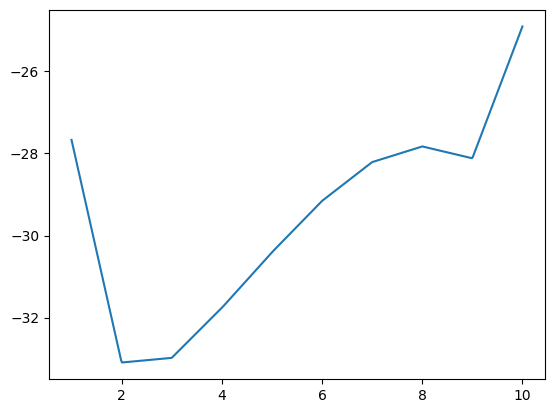

3 3
Convlayer 3


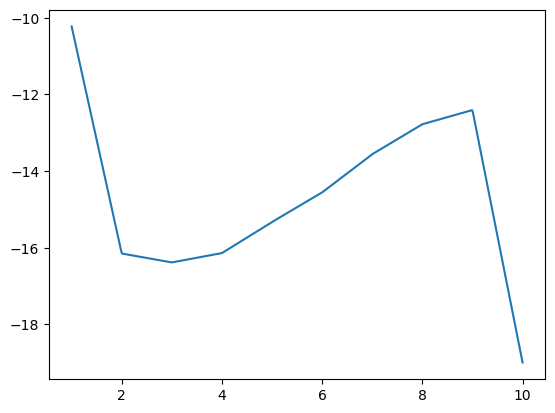

Courbe d'origine 4


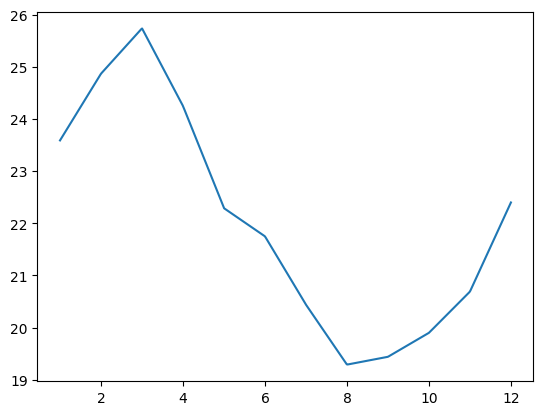

4 1
Convlayer 1


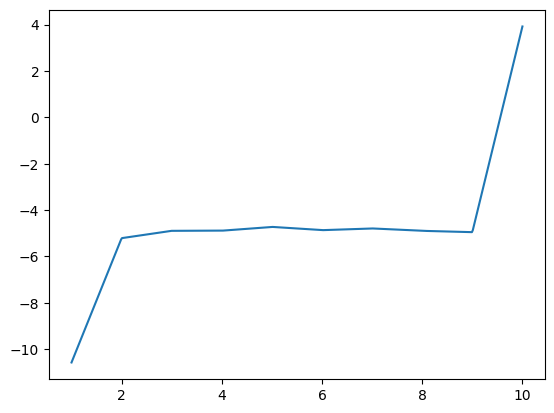

4 2
Convlayer 2


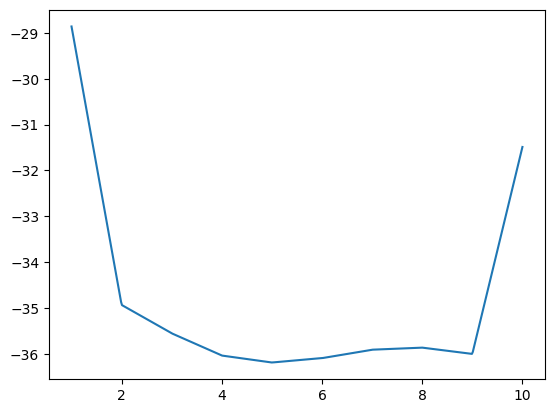

4 3
Convlayer 3


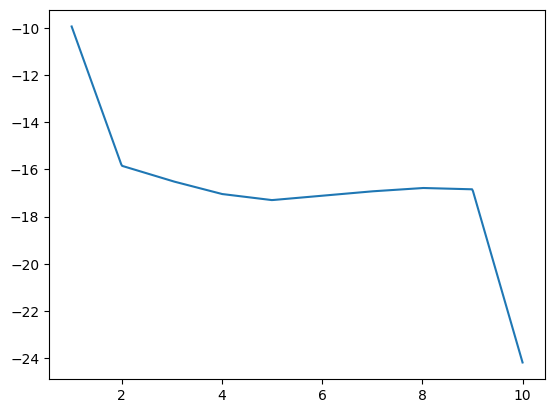

In [132]:
# CEDRIC: Pourquoi visualizer les layers AVANT entrainement ?
output_CNN_FAE=CNN.CNN_Conv(X_train[1,:].unsqueeze(0))
n_conv_out=Conv_out.shape[2]
basis_conv_out=skfda.representation.basis.BSplineBasis(knots=linspace(1,n_conv_out,4))
print(["conv_out shape=",Conv_out.shape])
Conv_out.shape
for i in range(4):
        print("Courbe d'origine",i+1)
        fd(x0[i,:].detach().cpu(),grid_points=grid_points).plot()
        plt.show()
        for j in range(3):
            print(i+1,j+1)
            print("Convlayer",j+1)
            CNN.FD=fd(Conv_out[i,j,:].detach().cpu(),grid_points=linspace(1,n_conv_out,n_conv_out))
            CNN.FD.plot()
            plt.show()
            #CNN.FD.to_basis(basis_conv_out).plot()
            #print("Smoothed convlayer")
            #plt.show()


In [133]:

Lin_out=CNN.Linear(Conv_out)
print(Lin_out.shape)
n_Linout=Lin_out.shape[1]



torch.Size([111, 4])


In [305]:
# i=7
# train_loss=torch.tensor(0).cuda().long()
# functions_train=x_train[batch_size*i:batch_size*(1+i),:,:]
# labels_train=y_train[batch_size*i:batch_size*(1+i)]
# optimizer.zero_grad()
# output=CNN(functions_train)
# output.shape   
# labels_train.shape   
# loss=loss_function(input=output,target=labels_train.unsqueeze(1).long())
# print(loss)
# loss.backward()
# print(loss)
# train_loss+=loss.long
# print(train_loss)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 3)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 3)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [360]:
CNN=FCNN().cuda()
CNN=CNN.apply(weights_init_normal)

In [361]:
# CEDRIC: Juste changé batch size et optim et je suis aller chercher 90% accurace
lr=0.001
betas=[0.5,0.999]
batch_size=30

loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(CNN.parameters(),lr=lr)



#print("Loader entier=",train_loader.dataset.shape)
#for i,b in enumerate(train_loader):
#    print ("Itération du",i,"ème batch=",b.shape)


In [362]:
# CEDRIC: Je suis aps convaincu que dans sa forme actuelle tu as implementé ce que tu propose; je ne pense pas que la x_train est évaluer a plusieurs point et qu'onf ait un stride *continue*
from tqdm import tqdm
def train(n_epochs):
    train_loss=torch.tensor(0).cuda().long()
    train_loader=torch.utils.data.DataLoader([x,labels],batch_size=batch_size)
    for i in range(int(len(x_train)/batch_size)):
        functions_train=x_train[batch_size*i:batch_size*(1+i),:,:]
        labels_train=y_train[batch_size*i:batch_size*(1+i)]
        optimizer.zero_grad()
        output=CNN(functions_train)
        loss=loss_function(input=output,target=labels_train.unsqueeze(1).long())
        loss.backward()
        optimizer.step()
        train_loss+=loss.long()
    return train_loss,loss 

        


        


In [387]:
train(1)

(tensor(115, device='cuda:0'),
 tensor(1.6943, device='cuda:0', grad_fn=<NllLoss2DBackward0>))

In [383]:
torch.sum(torch.argmax(CNN(x_test),dim=1).squeeze(1)==y_test)/37

tensor(0.5405, device='cuda:0')

In [386]:
torch.mean(torch.square(CNN(x_test)-y_test))


tensor(164.8815, device='cuda:0', grad_fn=<MeanBackward0>)

In [388]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

74